# Project Overview
Years ago I made a project that classified spam and non spam texts. The notebook was very slopy and did not make a lot of sense. It is a fairly easy task but did not get its right explanation and attention in the previous notebook so I will be re doing it. In this updated version of the notebook I will explore the data. For this notebook I've choose to use naive bayes as the model. Before the model creation I will also go over the math behind naive bayes. Lastly I will evaluate the results and give my conclusion. This notebook goes over some of the math that is used in Naive Bayes, knowledge about probability theory would be helpful for some part of the notebook. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Above we have imported some librarires. The data is in file called `data`. This is pretty straight forward we just load it in using pandas. Once we load it in we will exploring the data.

In [2]:
data = pd.read_csv("./data", sep="\t", names=["label", "message",]) # load in data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


From this we know that we have a total of 5572 samples. We have no null values and they are both object types. Before we get into data exploration it would be helpful to first make the labels `int` type. Lets first see what our data looks like.

In [4]:
data.head()

,label,message
0,spam,URGENT! This is the 2nd attempt to contact U!U...
1,ham,:( but your not here....
2,ham,Not directly behind... Abt 4 rows behind ü...
3,spam,Congratulations ur awarded 500 of CD vouchers ...
4,spam,Had your contract mobile 11 Mnths? Latest Moto...


To start with we first need to turn our labels into numerical values. `Spam` will be represented by `1` and `Ham` (no spam) will be represented by `0`.

In [5]:
# converting text label into numerical values such as ham=0, spam=1
label_mapping = {'ham': 0, 'spam': 1}
data['label'] = data['label'].map(label_mapping)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   int64 
 1   message  5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [7]:
data['label'].value_counts() # count how much of spam and non spam messages we have

label
0    4825
1     747
Name: count, dtype: int64

We have a small ammount of `spam` messages compared to `ham` messages. We have a total of `4825` `ham` messages and `747 spam` messages. This is very unbalanced so we will see what the results are. It is good to have equal ammount of examples from each class when doing classification. `747` `spam` messages is still a good amount for us to train on. We have a lot of `spam` examples which is good. This means that our model will have a lot of examples to learn to detect spam correctly. LEts continue exlporing our data!

In [8]:
data['message'] = data['message'].str.lower() # convert messages lowercase

In [9]:
data.head(10)

,label,message
0,1,urgent! this is the 2nd attempt to contact u!u...
1,0,:( but your not here....
2,0,not directly behind... abt 4 rows behind ü...
3,1,congratulations ur awarded 500 of cd vouchers ...
4,1,had your contract mobile 11 mnths? latest moto...
5,1,urgent! call 09066350750 from your landline. y...
6,0,no plans yet. what are you doing ?
7,0,hi ....my engagement has been fixd on &lt;#&g...
8,0,not course. only maths one day one chapter wit...
9,0,wow didn't think it was that common. i take it...


It would be helpful to see which words appear in spam messages the most. This would help us see if certains words contribute more to a message being `spam`. What we will do first is remove stop words Stop words are words like `the`, `to` and `a`. The reason for this is because it is highly likely that these words appear in both `spam`and `ham` messages and would have little to know affect on detecting `spam`.

In [10]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

I had to download stop words from [here](https://gist.github.com/sebleier/554280). Then I put the list in my `env` folder. 

In [11]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    words = text.split() 
    filtered_words = [word for word in words if word.lower() not in stop_words]  
    return ' '.join(filtered_words)

In [12]:
data['message'] = data['message'].apply(remove_stopwords)

Now we want to create two dataframes one for `spam` messages and the other for `ham` messaages. 

In [13]:
spam = data[data['label'] == 1] # seperate the data
ham = data[data['label'] == 0]

Then we create a list of all the words in our message. One list for `spam` and one for `ham`.

In [14]:
spam_words = ' '.join(spam['message']).lower().split() # crate a list of spam and ham words
ham_words = ' '.join(ham['message']).lower().split()

In the cell below we count the occurence of our words. After that we will create two dataframes (one for `spam` and one for `ham`). Both will have columns `word` and `count`. 

In [15]:
spam_word_counts = Counter(spam_words) # count the words
ham_word_counts = Counter(ham_words)

In [16]:
# make a dataframe with the word and its count
spam_word_count_df = pd.DataFrame(spam_word_counts.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)
ham_word_count_df = pd.DataFrame(ham_word_counts.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

In [17]:
spam_word_count_df.head()

,word,count
47,call,342
20,free,180
22,2,169
12,ur,144
26,txt,136


Here we can see that `call` appears `432` times in the spam messages. Free appears `180` times in spam messages.  

In [18]:
ham_word_count_df.head(5)

,word,count
44,u,881
150,get,293
149,2,288
16,&lt;#&gt;,276
41,ur,241


In non spam messages the most common word or symbol is `u` which appears `861` times. Then `get` appears 293 times. However a word like `ur` appears frequently in both `spam` and `ham`. For example in `spam` messages `ur` appears `144` times. While in `ham` messages `ur` appears `241` times. The count is very valuable and will be used in our modeling in naivey bayes. If we only knew the words that appeared the most in each message and not the count we could run into issues whem modeling. Moving on lets graph the 10 most frequent words in both dataframes.

Text(0, 0.5, 'count')

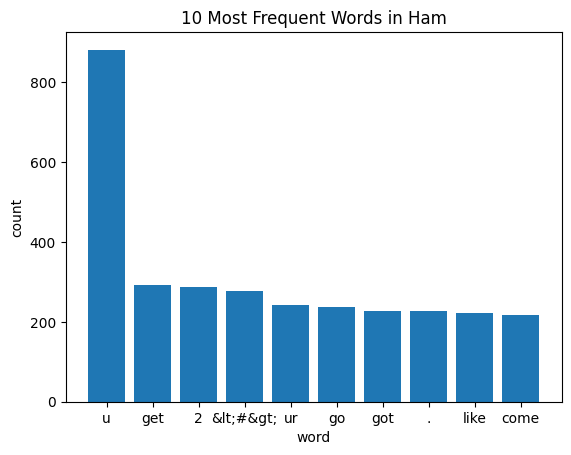

In [19]:
plt.bar(ham_word_count_df.head(10)['word'], ham_word_count_df.head(10)['count'])
plt.title('10 Most Frequent Words in Ham')
plt.xlabel('word')
plt.ylabel('count')

The 10 most frequent words in our `ham` messages are `u, get, 2, &lt;#&gt;, ur, go, got, ., like` and `come`. This makes sense as they seem like pretty standard words. Words like `go`, `get`, or `come` could be invations or making plans. Although they are invitational words like youd see in `spam` messages they appear frequently in `ham` which makes a difference. I'm not sure what `&lt;#&gt;` is but ideally we would remove it, same with `.`.  Lets move onto the `spam` words

Text(0, 0.5, 'count')

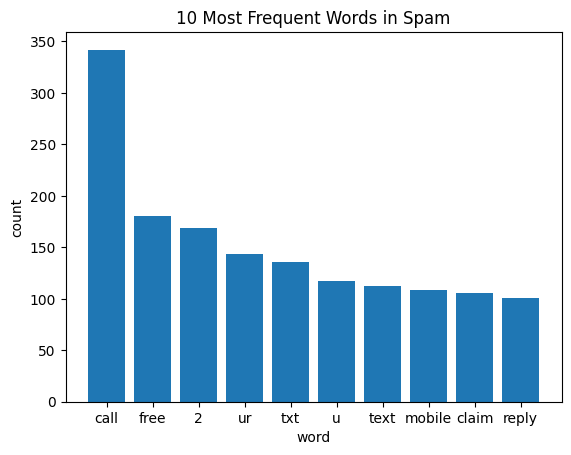

In [20]:
plt.bar(spam_word_count_df.head(10)['word'], spam_word_count_df.head(10)['count'])
plt.title('10 Most Frequent Words in Spam')
plt.xlabel('word')
plt.ylabel('count')

The 10 most frequent words in our `ham` messages are `call, free, 2, ur, txt, u, text, mobile, claim` and `reply`. A lot of these words imply that you have won something. For example `free, claim, reply` seem like someone is alerting you that you won something and must reply to clain it. These words make sense for being here. It is interesting to see that `call` appears so many more times compared to other words.

## Math
Now that we have learned about our data its time to begin learning about naive bayes and the math behind it. Naive Bayes uses probability theory specifically Bayes Theorem. Here are some further readings on [Bayes Theorem]() and [Naive Bayes](). First lets go over some proability basics. \

**Def 1:** $X$ denotes a random variable

**Def 2:** $P(X=x)$ denotes the probability of a random varible $X$ taking on some value $x$ 

**Def 3:**  $P(X=x|Y=y)$ denotes the probability of a random variable $X$ taking on some value $x$ given the the random variable $Y$ has taken on some value $y$. This is known **conditional probability**. 

**Def 4:**  $P(X=x \cap Y=y)$ the **intersection** of X and Y. This is the probability that X and Y happen. 

**Def 5:** $P(X=x|Y=y) = \frac{P(X=x \cap Y=y)}{P(Y=y)}$ How we calculate condtional probability.

**Def 6:** $P(X=x|Y=y) = \frac{P(Y=y|X=x)P(X=x)}{P(Y=y)}$  This is bayes theorem. 

<!-- To derive Bayes Theorem its a simple substitution. The probability of X and Y is the same as the probability of Y and X $P(X \cap Y) = P(Y \cap X)$. Below is our conditional probability we are going to substitute $P(X \cap Y)$ with $P(Y \cap X)$.
$$P(X=x | Y=y) = \frac{P(X=x \cap Y=y)}{P(Y=y)} = \frac{P(Y=y \cap X=x)}{P(Y=y)}$$

Conditional probability says that $P(Y=y|X=x)=\frac{P(Y=y\cap X=x)}{P(X=x)} $. If we solve for $P(Y=y \cap X=x)$ we get $P(Y=y \cap X=x) = P(Y=y|X=x) P(X=x)$. If we plug that into to our equation above we arrive at our equation for bayes theorem.
$$ P(X=x|Y=y) = \frac{P(Y=y|X=x)P(X=x)}{P(Y=y)}$$ -->

These defenitions above will help us in our goal to classify spam messages. We could use bayes theorem as it is now but there are some changes we can do first. So because we are interested in the probability of a message X being spam given the words in the message i.e. $P(X=\text{spam}| Y = \text{words})$ we do not need $P(Y=\text{words})$. This is because probability of seeing the words regardless of class will be constant. They dont depend on the class (ham or spam).
Our equation now becomes 
$$ P(X=x|Y=y) = P(Y_{1 \dots n}=y_{1 \dots n}|X=x)P(X=x) $$
Now if want to calculate straight from here our equation would look something like this 
$$ P(X=x|Y_{1 \dots n}=y_{1 \dots n}) = P(Y_{1 \dots n}=y_{1 \dots n}|X=x)P(X=x) $$
$$ = P(Y_1=y_1 \dots Y_n=y_n , X=x)P(X=x) $$
$$ = P(Y_1=y_1|Y_2=Y_2 \dots Y_n=y_n, X=x) \dots P(Y_n=Y_n|X=x)P(X=x) $$
The final equation above can be a lot to compute. This is where the naive part of Naive Bayes comes into play. If we assume that the features (words) are independent then we can write the equation as this 
$$ = P(X_1=x_1|Y_n=y_n) \dots P(X_n=x_n|Y=y)P(X=x) $$
This can be simplified to
$$P(X=x|Y_1=y_1 \dots Y_n=y_n) = P(X=x) \prod\limits_{i=1}^n P(Y_i=y_i|X=x) $$
This is a lot simpler to compute.  

We have our final equation that will allow us to classify messages. Now lets go over an example. Our goal is to classify detect spam given some message. Rephrasing that into probability theory we want to know what the probability of a message being spam given the words to the message. In math we have: 
$$P(\text{message is spam}|\text{words in message})$$
Let's define some random variables. Let $X$ denote the event that a message is spam. Let $Y_{1 \dots n}=y_{1 \dots n}$ denote the event that our message contains some word. For example $Y_1=y_1$ could denote that the message contains the word `free`, $Y_2=y_2$ could denote `car` etc. The math for that would then be:
$$P(X=spam|Y_{1 \dots n}=y_{1 \dots n}) = P(X=\text{spam}) P(Y_1=\text{free}|X=\text{spam}) P(Y_2=\text{car}|X=\text{spam})$$

The equation above says that the probability that our message is spam given it contains the words `free` `car` is given by the probability of spam message occuring times the probability of the seeing the word `free` given in a spam message times the probability of seeing the word `car` in a spam message. Lets calculate an actual example. The table below will serve as a sample dataset.

| Message              | Label | 
| :---------------- | ------: | 
| congrats u won a phone        |   spam   | 
| how are u         |   ham   | 
| are u ready for the trip  |  ham  | 
| congrats free tickets |  spam   |
| claim free car |  spam   |

<!-- | Word              | Count | 
| :---------------- | ------: | 
| free         |   3   | 
| phone         |   1   | 
| how  |  1  | 
| are |  2   |
| u |  2   |
| ready |  1   |
| for |  1   |
| the |  1   |
| trip |  1   |
| congrats |  1   |
| tickets |  1   |
| claim |  1   |
| car |  1   | -->

Lets say we have the incoming message `want free a macbook`. 
Our equation would be 
$$ 
P(X=\text{spam} | Y_1 = \text{want}, Y_2=\text{a}, Y_3=\text{free}, Y_4={macbook})
$$
The equation above asks what is the probability that the message containg the words `want` `a` `free` `macbook` is spam. Using bayes theorem lets try and solve this. 

$$ 
P(X=\text{spam} | Y_1 = \text{want}, Y_2=\text{a}, Y_3=\text{free}, Y_4={macbook})
$$
$$ = P(X=\text{spam}) P(Y_1=\text{want}| X=\text{spam})P(Y_2=\text{a}| X=\text{spam}) P(Y_3=\text{free}| X=\text{spam}) 
P(Y_4=\text{macbook}| X=\text{spam})
$$
In English this says that the probability of our message `want a free macbook` being spam is the probability of a spam message times the probability of each word occuring in a spam message. Lets calculate this. 
- Probability of a message being spam is $P(X=\text{spam}) = \frac{3}{6}$  because we have three message in our dataset of five. 
- Probability of the word `want` being in a spam message is $P(Y_1=\text{want}|X=\text={spam}) = \frac{0}{3}$. Because the word want does not appear in a spam message in our dataset. This means we assign it zero but this would mean that that the entire probability is 0 which is incorrect. A work around for this is to add one appearance to each of the words and each example. Meaning $P(Y_1=\text{want}|X=\text={spam}) = \frac{1}{4}$. This is called smoothing. 
- Probability of the word `a` being in a spam message is $P(Y_2=\text{a}|X=\text={spam}) = \frac{1}{4}$ because `a` appears in the in one spam message `congrats u won a phone`
- Probability of the word `free` being in a spam message is $P(Y_3=\text{free}|X=\text={spam}) = \frac{2}{4}$ because the word `free` appears in two messages.
- Probability of the word `macbook` being in a spam message is $P(Y_3=\text{macbook}|X=\text={spam}) = \frac{1}{4}$.

This leads us to 
$$P(X=\text{spam} | Y_1 = \text{want}, Y_2=\text{a}, Y_3=\text{free}, Y_4={macbook}) = \frac{3}{5}\frac{1}{4}\frac{1}{4}\frac{2}{4}\frac{1}{4} = $$

This is a very basic example. In our case we have many samples to go off of. This was the math explanation for what we are about to do. Lets start modeling. 

## Model Building
As mentioned above I am going to use naive bayes. This part is pretty straight forward. First what we are going to do is get features for our data. This means we will pass our data into a library that will give us the word frequency in messages. This way we know what words appear in spam and not spam messages so we can do what we did above.  

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

Below we are going to get features which are frequency of words using `CountVectorizer`.

In [42]:
vectorizer = CountVectorizer(stop_words='english') 

In [43]:
X = vectorizer.fit_transform(data['message']) 
y = data['label']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now its time to fit our model.

In [45]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

We have fit the data now we want to get the predictions on our test data. 

In [ ]:
y_pred = model.predict(X_test)

In [47]:
accuracy = accuracy_score(y_test, y_pred)

In [65]:
f'Accuracy: {accuracy}'

'Accuracy: 0.9802690582959641'

Our accuracy on the test data is pretty high! This is a sign. Lets create a confusion matrix to see how our model is classifying things. 

In [68]:
cm = confusion_matrix(y_test, y_pred) # create a confusion matrix

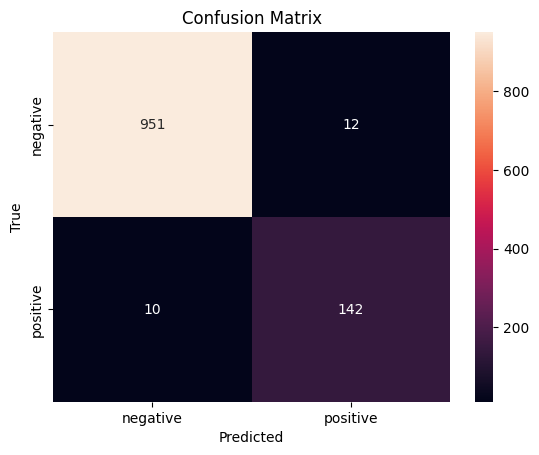

In [74]:
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Above we have our confusion matrix. Lets breakdown what it is telling us. On the left `X axis` we have the true values for the samples and on the `Y axis` we have the prediction from our model. We want a matrix that is strictly diagonally dominant which means that the diagonal elements are the highest values in the rows. Our matrix is strictly diagonally dominant from top left to bottom right. 

Our matrix tells us that our model correctly predicted a `non spam` message 951 times (`True Negative`). It tells us that our model incorrectly classified a `non spam` message as `spam` 10 times (`False Positive`). It correctly classified a 142 of `spam` messages (`True Positive`). Lastly our model incorrectly classified 12 `spam` messages as `non spam` (`False Negative`). Our confusion matrix tells us that our model seems to be classifying both classes of messages correctly. Lets now try an an example of our own. 

In [75]:
messages = ['are u free tonight?', 'txt to claim free phone']
messages = vectorizer.transform(messages)
prediction = model.predict(messages)

In [76]:
prediction

array([0, 1])

We passed in two messages `'are u free tonight?'` and `'txt to claim free phone'`. The first one is `non spam` and the second one is `spam`. If we remember from the beggining `0` is `non spam` and `1` is `spam`. Our model predicted our samples correctly!

## Conclusion
In conclusion Naive Bayes classifiers are a very powerful tool. We saw we were able to create a model to classify `spam` and `non spam` messages. It worked very well too. There is still the limitation of assuming that the features are independent. I'm glad I revisited this notebook and improved it. I have learned a lot since first working on this problem years ago. I will be working on other notebooks now. Thank you for reading :)